In [13]:
# Instala a biblioteca OR-Tools
%pip install ortools

Note: you may need to restart the kernel to use updated packages.


In [14]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model
import numpy as np

In [16]:
def solve_sample_allocation(n_samples, n_machines, costs, capacities, sample_names=None):
    """
    Resolve o problema de alocação de amostras para máquinas minimizando custo.
    
    Args:
        n_samples (int): Número de amostras
        n_machines (int): Número de máquinas
        costs (list): Custo por máquina
        capacities (list): Capacidade máxima por máquina
        sample_names (list): Nomes das amostras (opcional)
    
    Returns:
        dict: Resultado da otimização
    """
    
    # Validações básicas
    if sum(capacities) < n_samples:
        raise ValueError("Capacidade total insuficiente para todas as amostras")
    
    if len(costs) != n_machines or len(capacities) != n_machines:
        raise ValueError("Número de custos/capacidades deve corresponder ao número de máquinas")
    
    # Cria o modelo
    model = cp_model.CpModel()
    
    # Variáveis: assignment[s, m] indica se amostra s é alocada à máquina m
    assignment = {}
    for s in range(n_samples):
        for m in range(n_machines):
            assignment[(s, m)] = model.NewBoolVar(f'assign_{s}_{m}')
    
    # Restrições
    # 1. Cada amostra é alocada a exatamente uma máquina
    for s in range(n_samples):
        model.Add(sum(assignment[(s, m)] for m in range(n_machines)) == 1)
    
    # 2. Respeita a capacidade de cada máquina
    for m in range(n_machines):
        model.Add(sum(assignment[(s, m)] for s in range(n_samples)) <= capacities[m])
    
    # Objetivo: minimizar o custo total
    total_cost = sum(assignment[(s, m)] * costs[m] 
                    for s in range(n_samples) 
                    for m in range(n_machines))
    model.Minimize(total_cost)
    
    # Resolve o problema
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = False  # Remove logs desnecessários
    status = solver.Solve(model)
    
    # Processa resultados
    if status in [cp_model.FEASIBLE, cp_model.OPTIMAL]:
        allocation = []
        machine_loads = [0] * n_machines
        
        for s in range(n_samples):
            for m in range(n_machines):
                if solver.Value(assignment[(s, m)]):
                    sample_name = sample_names[s] if sample_names else f'Amostra {s+1}'
                    allocation.append({
                        'Sample': sample_name,
                        'Machine': f'Máquina {m+1}',
                        'Machine_ID': m,
                        'Cost': costs[m]
                    })
                    machine_loads[m] += 1
        
        return {
            'status': 'OPTIMAL' if status == cp_model.OPTIMAL else 'FEASIBLE',
            'allocation': pd.DataFrame(allocation),
            'total_cost': solver.ObjectiveValue(),
            'machine_loads': machine_loads,
            'solver_time': solver.WallTime()
        }
    else:
        return {
            'status': 'INFEASIBLE',
            'allocation': None,
            'total_cost': None,
            'machine_loads': None,
            'solver_time': solver.WallTime()
        }

In [17]:
def visualize_allocation(result, costs, capacities):
    """Cria visualizações da alocação."""
    if result['status'] == 'INFEASIBLE':
        print("Não é possível visualizar: solução inviável")
        return
    
    allocation_df = result['allocation']
    machine_loads = result['machine_loads']
    
    # Configurar subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Alocação por máquina
    machines = [f'Máquina {i+1}' for i in range(len(machine_loads))]
    colors = plt.cm.Set3(np.linspace(0, 1, len(machines)))
    
    bars = ax1.bar(machines, machine_loads, color=colors, alpha=0.7, edgecolor='black')
    
    # Adicionar linha de capacidade
    for i, capacity in enumerate(capacities):
        ax1.axhline(y=capacity, xmin=i/len(machines), xmax=(i+1)/len(machines), 
                   color='red', linestyle='--', alpha=0.7)
        ax1.text(i, capacity + 0.1, f'Cap: {capacity}', ha='center', va='bottom', 
                fontweight='bold', color='red')
    
    # Anotações com custo
    for i, (count, cost) in enumerate(zip(machine_loads, costs)):
        if count > 0:
            ax1.text(i, count/2, f'Custo/item:\n{cost}', ha='center', va='center', 
                    fontweight='bold', color='white')
    
    ax1.set_xlabel('Máquinas')
    ax1.set_ylabel('Número de Amostras Alocadas')
    ax1.set_title('Alocação de Amostras por Máquina')
    ax1.grid(True, axis='y', alpha=0.3)
    ax1.set_ylim(0, max(capacities) + 0.5)
    
    # Gráfico 2: Custo por máquina
    machine_costs = [loads * cost for loads, cost in zip(machine_loads, costs)]
    bars2 = ax2.bar(machines, machine_costs, color=colors, alpha=0.7, edgecolor='black')
    
    for i, cost in enumerate(machine_costs):
        if cost > 0:
            ax2.text(i, cost/2, f'{cost}', ha='center', va='center', 
                    fontweight='bold', color='white')
    
    ax2.set_xlabel('Máquinas')
    ax2.set_ylabel('Custo Total')
    ax2.set_title('Custo Total por Máquina')
    ax2.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [18]:
def print_detailed_results(result, costs, capacities):
    """Imprime resultados detalhados."""
    print("="*50)
    print("RESULTADOS DA OTIMIZAÇÃO")
    print("="*50)
    
    if result['status'] == 'INFEASIBLE':
        print("❌ PROBLEMA INVIÁVEL - Não há solução possível")
        return
    
    print(f"✅ Status: {result['status']}")
    print(f"💰 Custo total: {result['total_cost']} unidades")
    print(f"⏱️  Tempo de solução: {result['solver_time']:.3f}s")
    print()
    
    print("📋 ALOCAÇÃO DETALHADA:")
    print(result['allocation'].to_string(index=False))
    print()
    
    print("📊 RESUMO POR MÁQUINA:")
    for i, (load, capacity, cost) in enumerate(zip(result['machine_loads'], capacities, costs)):
        utilization = (load / capacity) * 100 if capacity > 0 else 0
        total_cost = load * cost
        print(f"  Máquina {i+1}: {load}/{capacity} amostras "
              f"({utilization:.1f}% utilização) - Custo: {total_cost}")

RESULTADOS DA OTIMIZAÇÃO
✅ Status: OPTIMAL
💰 Custo total: 600.0 unidades
⏱️  Tempo de solução: 0.004s

📋 ALOCAÇÃO DETALHADA:
 Sample   Machine  Machine_ID  Cost
Vinho_1 Máquina 2           1   150
Vinho_2 Máquina 2           1   150
Vinho_3 Máquina 1           0   100
Vinho_4 Máquina 1           0   100
Vinho_5 Máquina 1           0   100

📊 RESUMO POR MÁQUINA:
  Máquina 1: 3/3 amostras (100.0% utilização) - Custo: 300
  Máquina 2: 2/2 amostras (100.0% utilização) - Custo: 300


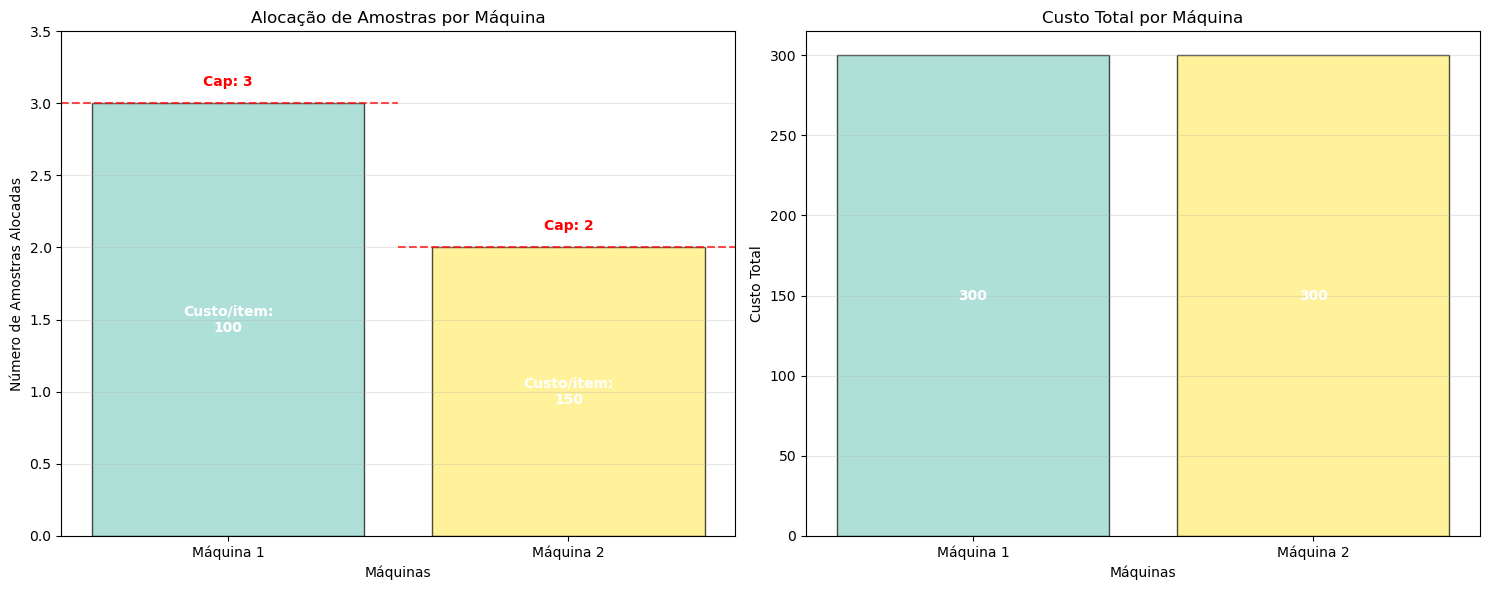


🔍 ANÁLISE DE SENSIBILIDADE:
E se aumentássemos a capacidade da Máquina 1?
Novo custo total: 600.0 (economia: 0.0)


In [19]:
# Exemplo de uso com dados mais realistas

# Configuração do problema
n_samples = 5
n_machines = 2
costs = [100, 150]  # Custo por amostra em cada máquina
capacities = [3, 2]  # Capacidade máxima de cada máquina

# Nomes das amostras (opcional)
sample_names = [f"Vinho_{i+1}" for i in range(n_samples)]

try:
    # Resolve o problema
    result = solve_sample_allocation(n_samples, n_machines, costs, capacities, sample_names)
    
    # Exibe resultados
    print_detailed_results(result, costs, capacities)
    
    # Visualiza resultados
    visualize_allocation(result, costs, capacities)
    
    # Análise de sensibilidade simples
    print("\n🔍 ANÁLISE DE SENSIBILIDADE:")
    print("E se aumentássemos a capacidade da Máquina 1?")
    
    new_capacities = [3, 3]
    result_new = solve_sample_allocation(n_samples, n_machines, costs, new_capacities, sample_names)
    print(f"Novo custo total: {result_new['total_cost']} "
            f"(economia: {result['total_cost'] - result_new['total_cost']})")
    
except ValueError as e:
    print(f"❌ Erro: {e}")